

## **Buisness Problem**: Retail Analysis (Cross-sell & Up-sell)



# **Dataset** 
(Online Retail.xlsx)

Here numpy is used becoz Numpy provides a high-performance multidimensional array and basic tools to compute with and manipulate the arrays.
Pandas library is used to do analysis of data. pandas help to analyse data.

In [ ]:
import numpy as np
import pandas as pd

Here we have clone the Github repository to import Online Retail Dataset.

In [ ]:
! git clone https://github.com/Swapnil-Damate/Upselling-and-cross-selling-.git



Cloning into 'Upselling-and-cross-selling-'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 46 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (46/46), done.


Import dataset from Git

In [ ]:
#/content/Upselling-and-cross-selling-/Online Retail.xlsx
#url = 'https://raw.githubusercontent.com/Swapnil-Damate/Upselling-and-cross-selling-/master/Online%20Retail.xlsx'
dataset = pd.read_excel('https://raw.githubusercontent.com/Swapnil-Damate/Upselling-and-cross-selling-/master/Online%20Retail.xlsx')





In [ ]:
df = dataset.copy()

To know data features:

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Dataset has 8 features: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country.

## **Exploratory Data Analysis (EDA)**

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Rearrange the dataset features.

In [ ]:
 df=df[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','Description','InvoiceDate','Country']]


here new fetures is added to dataset to know totalamount of  products

In [ ]:
       #Creating Total amount variable and adding it to dataset
TotalAmount=df['Quantity'].abs()*df['UnitPrice'].abs()
df.insert(loc=6,column='TotalAmount',value=TotalAmount)
df=df[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','TotalAmount','Description','InvoiceDate','Country']]
df.head()

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
0,17850.0,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850.0,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850.0,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850.0,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850.0,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom


Total amount of purchases for each customer

In [ ]:
                                                  #Total amount of purchases for each customer
new_df=df.groupby(['CustomerID']).sum()
new_df.sort_values('TotalAmount',ascending=False,inplace=True)
final_df = new_df[(new_df['Quantity']>0) & (new_df['TotalAmount'] > 0)]
final_df.head(10)

,Quantity,UnitPrice,TotalAmount
CustomerID,,,
16446.0,2,7.06,336942.10
14646.0,196719,5400.21,280923.02
18102.0,64122,5159.73,262876.11
17450.0,69029,3320.09,201619.41
14911.0,77180,31060.66,155077.50
12415.0,77242,2499.82,126103.61
14156.0,57025,6544.29,121375.12
16029.0,32148,24111.14,111057.07
17511.0,63012,2607.08,93999.38


In [ ]:
dff = df.copy()
dff = dff.drop('CustomerID',axis=1)

Correlation between dataset features.
Unitprice and Quantity has negative correlation.
Unitprice and TotalAmount has positive correlation.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


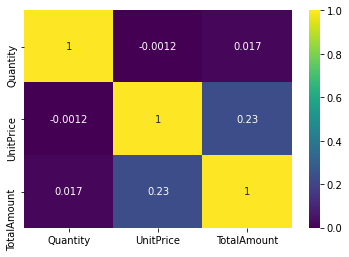

In [ ]:
import seaborn as sns
sns.heatmap(dff.corr(),annot=True,cmap='viridis')

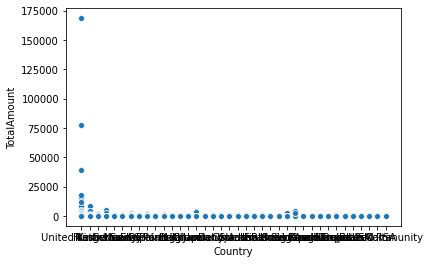

In [ ]:
sns.scatterplot(x='Country',y='TotalAmount',data=df)

Customer who paid most and least
Customer 4317 has paid minimu amount.

In [ ]:
                                                             #Customer who paid most and least
print('Customer ID {} had paid maximum amount of {}'.format(int(final_df['TotalAmount'].argmax()),final_df['TotalAmount'].max()))
print('Customer ID {} had paid minimum amount of {}'.format(int(final_df['TotalAmount'].argmin()),final_df['TotalAmount'].min()))

Customer ID 0 had paid maximum amount of 336942.1
Customer ID 4317 had paid minimum amount of 3.75


Maximum and Minimum no. of quantity and it's corresponding customer ID 
Maximim products are bought by customer id 1.
Minimum products are bought by customer id 907

In [ ]:
                                                            #Maximum and Minimum no. of quantity and it's corresponding customer ID 
print('The maximum number of products has been bought is {} by customer id {}'.format(final_df['Quantity'].max(),final_df['Quantity'].argmax()))
print('The minimum number of product has been bought is {} by customer id {}'.format(final_df['Quantity'].min(),final_df['Quantity'].argmin()))

The maximum number of products has been bought is 196719 by customer id 1
The minimum number of product has been bought is 1 by customer id 907


Total sales at each country and how many quantities sold at each country

In [ ]:
                                            #Total sales at each country and how many quantities sold at each country
country=df.groupby(['Country']).sum()
country.sort_values('TotalAmount',ascending=False,inplace=True)
country.drop('CustomerID',axis=1,inplace=True)
country.head()

,Quantity,UnitPrice,TotalAmount
Country,,,
United Kingdom,4263829,2.245715e+06,9.862638e+06
EIRE,142637,4.844719e+04,3.036311e+05
Netherlands,200128,6.492550e+03,2.862311e+05
Germany,117448,3.766600e+04,2.360361e+05
France,110480,4.303199e+04,2.220263e+05


# **Data Cleaning / Data Preprocessing**

In [ ]:
df.shape

(541909, 9)

To find Count, mean, standard, minimum, maximum

In [ ]:
df.describe()

,CustomerID,Quantity,UnitPrice,TotalAmount
count,406829.000000,541909.000000,541909.000000,541909.000000
mean,15287.690570,9.552250,4.611114,21.379274
std,1713.600303,218.081158,96.759853,378.634556
min,12346.000000,-80995.000000,-11062.060000,0.000000
25%,13953.000000,1.000000,1.250000,3.750000
50%,15152.000000,3.000000,2.080000,9.900000
75%,16791.000000,10.000000,4.130000,17.700000
max,18287.000000,80995.000000,38970.000000,168469.600000


To remove extra spaces in Description if present

In [ ]:

df['Description'] = df['Description'].str.strip()

To remove NaN entries, To convert invoiceNo & Stockcode data type to string

In [ ]:
#Drop NaN Entries
df.dropna()
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')
df.shape

(541909, 9)

We have to deal with only live transactions not with cancelled/ Returned transaction.

In [ ]:
#Remove cancelled/Retured Transaction
df = df[~df['InvoiceNo'].str.contains('C')]

df = df[~df['InvoiceNo'].str.contains('A')]


# **Evaluate Algorithm**

Import libraries like fpgrowth, assocition rules and apriori to apply reccomendation algorithms on dataset.

In [ ]:
!pip install mlxtend==0.17.0
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

     |████████████████████████████████| 1.3MB 2.9MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


After the cleaned up we have consolidate the items into one transaction(Order ID) per row with each product name.

In [ ]:
basket_Germany = (df[df['Country'] == 'Germany']
             .groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket_Germany.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are lot of zeros in data but we have to make sure that all positive quantities are converted to one and others is set to zero.

In [ ]:
def encode_units(x):
  
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket_Germany.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

## Apriori Algorithm

Apply apriori and association rule on dataset and to generate frequent itemsets that have minimum support less than 0.02%. for association rule we have set minimum threshold to 0.7

In [ ]:
frequent_items = apriori(basket_sets, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=0.7)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ROUND SNACK BOXES SET OF4 WOODLAND),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.245077,0.041575,0.021882,0.089286,2.147556,0.011693,1.052388
1,(3 PIECE SPACEBOY COOKIE CUTTER SET),(ROUND SNACK BOXES SET OF4 WOODLAND),0.041575,0.245077,0.021882,0.526316,2.147556,0.011693,1.593727
2,(6 RIBBONS RUSTIC CHARM),(CHOCOLATE BOX RIBBONS),0.102845,0.037199,0.021882,0.212766,5.719650,0.018056,1.223017
3,(CHOCOLATE BOX RIBBONS),(6 RIBBONS RUSTIC CHARM),0.037199,0.102845,0.021882,0.588235,5.719650,0.018056,2.178806
4,(6 RIBBONS RUSTIC CHARM),(PLASTERS IN TIN CIRCUS PARADE),0.102845,0.115974,0.024070,0.234043,2.018065,0.012143,1.154145


Frequent Itemsets that have confidence more than 80%

In [ ]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.80) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
49,(BLUE POLKADOT BOWL),(RED RETROSPOT CUP),0.032823,0.070022,0.026258,0.800000,11.425000,0.023960,4.649891
64,(BLUE STRIPE CERAMIC DRAWER KNOB),(RED STRIPE CERAMIC DRAWER KNOB),0.028446,0.045952,0.024070,0.846154,18.413919,0.022763,6.201313
66,(BLUE STRIPE CERAMIC DRAWER KNOB),(WHITE SPOT RED CERAMIC DRAWER KNOB),0.028446,0.052516,0.024070,0.846154,16.112179,0.022576,6.158643
69,(PINK VINTAGE SPOT BEAKER),(BLUE VINTAGE SPOT BEAKER),0.024070,0.030635,0.024070,1.000000,32.642857,0.023333,inf
88,(CHARLOTTE BAG SUKI DESIGN),(WOODLAND CHARLOTTE BAG),0.045952,0.126915,0.037199,0.809524,6.378489,0.031367,4.583698
101,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.048140,0.050328,0.039387,0.818182,16.256917,0.036965,5.223195
110,(COFFEE MUG PEARS DESIGN),(COFFEE MUG APPLES DESIGN),0.039387,0.061269,0.035011,0.888889,14.507937,0.032598,8.448578
124,(DINOSAUR PARTY BAG + STICKER SET),(WOODLAND PARTY BAG + STICKER SET),0.021882,0.067834,0.021882,1.000000,14.741935,0.020398,inf
126,(DOLLY GIRL CHILDRENS BOWL),(DOLLY GIRL CHILDRENS CUP),0.026258,0.024070,0.024070,0.916667,38.083333,0.023438,11.711160
127,(DOLLY GIRL CHILDRENS CUP),(DOLLY GIRL CHILDRENS BOWL),0.024070,0.026258,0.024070,1.000000,38.083333,0.023438,inf


# FpGrowth Algorithm

In [ ]:
frequent_items2 = fpgrowth(basket_sets,
                          min_support = 0.02, use_colnames = True)
rules2 = association_rules(frequent_items2, metric="lift", min_threshold=1)
rules2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JUMBO BAG WOODLAND ANIMALS),(WOODLAND CHARLOTTE BAG),0.100656,0.126915,0.048140,0.478261,3.768366,0.035365,1.673414
1,(WOODLAND CHARLOTTE BAG),(JUMBO BAG WOODLAND ANIMALS),0.126915,0.100656,0.048140,0.379310,3.768366,0.035365,1.448942
2,(PLASTERS IN TIN WOODLAND ANIMALS),(JUMBO BAG WOODLAND ANIMALS),0.137856,0.100656,0.028446,0.206349,2.050035,0.014570,1.133173
3,(JUMBO BAG WOODLAND ANIMALS),(PLASTERS IN TIN WOODLAND ANIMALS),0.100656,0.137856,0.028446,0.282609,2.050035,0.014570,1.201777
4,(ROUND SNACK BOXES SET OF4 WOODLAND),(JUMBO BAG WOODLAND ANIMALS),0.245077,0.100656,0.037199,0.151786,1.507958,0.012531,1.060279


In [ ]:
Rules = rules2[ (rules2['lift'] >= 6) &
       (rules2['confidence'] >= 0.80) ]
Rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.035011,0.063457,0.032823,0.93750,14.773707,0.030601,14.984683
45,"(JUMBO BAG RED RETROSPOT, WOODLAND CHARLOTTE BAG)",(JUMBO BAG WOODLAND ANIMALS),0.024070,0.100656,0.024070,1.00000,9.934783,0.021647,inf
158,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.84375,6.648168,0.050194,5.587746
170,"(ROUND SNACK BOXES SET OF4 WOODLAND, RED RETRO...",(WOODLAND CHARLOTTE BAG),0.030635,0.126915,0.030635,1.00000,7.879310,0.026747,inf
176,"(SPACEBOY LUNCH BOX, RED RETROSPOT CHARLOTTE BAG)",(WOODLAND CHARLOTTE BAG),0.021882,0.126915,0.021882,1.00000,7.879310,0.019105,inf


# Result Visualization

In [ ]:
#result.to_excel('/content/drive/My Drive/Internship Model Result/Final_retail_result.xlsx')
final_Table = pd.read_excel('https://raw.githubusercontent.com/Swapnil-Damate/Upselling-and-cross-selling-/master/Final_onlineretail_result.xlsx')
#final_Table = pd.read_excel('/content/Upselling-and-cross-selling-/Final_onlineretail_result.xlsx')
final_Table = final_Table.drop('Unnamed: 0', axis=1)
final_Table = final_Table.drop('Unnamed: 0.1', axis=1)
final_Table = final_Table.replace()
final_Table

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,JAM JAR WITH GREEN LID,JAM JAR WITH PINK LID,0.035011,0.063457,0.032823,0.937500,14.773707,0.030601,14.984683
1,"JUMBO BAG RED RETROSPOT, WOODLAND CHARLOTTE BAG",JUMBO BAG WOODLAND ANIMALS,0.024070,0.100656,0.024070,1.000000,9.934783,0.021647,inf
2,RED RETROSPOT CHARLOTTE BAG,WOODLAND CHARLOTTE BAG,0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746
3,"ROUND SNACK BOXES SET OF4 WOODLAND, RED RETROS...",WOODLAND CHARLOTTE BAG,0.030635,0.126915,0.030635,1.000000,7.879310,0.026747,inf
4,"RED RETROSPOT CHARLOTTE BAG, SPACEBOY LUNCH BOX",WOODLAND CHARLOTTE BAG,0.021882,0.126915,0.021882,1.000000,7.879310,0.019105,inf
5,"RED RETROSPOT CHARLOTTE BAG, RED TOADSTOOL LED...",WOODLAND CHARLOTTE BAG,0.024070,0.126915,0.024070,1.000000,7.879310,0.021015,inf
6,"JUMBO BAG WOODLAND ANIMALS, RED RETROSPOT CHAR...",WOODLAND CHARLOTTE BAG,0.024070,0.126915,0.021882,0.909091,7.163009,0.018827,9.603939
7,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,0.035011,0.078775,0.032823,0.937500,11.901042,0.030065,14.739606
8,"JUMBO BAG WOODLAND ANIMALS, JUMBO BAG PINK POL...",JUMBO BAG RED RETROSPOT,0.026258,0.078775,0.026258,1.000000,12.694444,0.024190,inf
9,"JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROSPOT",JUMBO BAG WOODLAND ANIMALS,0.032823,0.100656,0.026258,0.800000,7.947826,0.022954,4.496718


##**MODEL**

# CROSS-SELL

1.

In [ ]:
def recme(antecedents):
  consequent = final_Table.loc[final_Table['antecedents'] == antecedents, 'consequents'].tolist()
  return consequent[0]
  #This function accepts antecedents(Product) from customer and give corresponding consequents(Reccomendation) based on algorithm results



In [ ]:
recme('SPACEBOY CHILDRENS CUP')

'SPACEBOY CHILDRENS BOWL'

2. Cosine similarities

In [ ]:
data_ib = (df[df['Country'] == 'Germany']
             .groupby(['CustomerID', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('CustomerID'))
data_ib.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12426.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12427.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12468.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,25.0,25.0,25.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_ib=data_ib.reset_index()
data_ib.head()

Description,CustomerID,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
0,12426.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12427.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12468.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,25.0,25.0,25.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_ib=data_ib.drop('CustomerID', 1)
data_ib.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,25.0,25.0,25.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Description v/s Description
data_ibs = pd.DataFrame(index=data_ib.columns,
                        columns=data_ib.columns)
data_ibs.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
Description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 COLOUR SPACEBOY PEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 COLOURED PARTY BALLOONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 IVORY ROSE PEG PLACE SETTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 MESSAGE CARDS WITH ENVELOPES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 PENCIL SMALL TUBE WOODLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_ibs = data_ibs.fillna(0)

In [ ]:
from scipy.spatial.distance import cosine
for i in range(0,len(data_ibs.columns)) :
    ''' Loop through the columns for each column '''
    for j in range(0,len(data_ibs.columns)) :
      ''' Fill in placeholder with cosine similarities '''
      data_ibs.iloc[i,j] = 1-cosine(data_ib.iloc[:,i],data_ib.iloc[:,j])
#Take too time for execution

In [ ]:
data_ibs.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
Description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 COLOUR SPACEBOY PEN,1.000000,0.342997,0.0,0.000000,0.469831,0.230631,0.213979,0.0,0.0,0.0,0.292509,0.242536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064249,0.00000,0.351702,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.146254,0.0,0.026003,0.000000,0.46676,0.342997,0.183340,0.0,0.0,0.214819,...,0.140028,0.0,0.0,0.0,0.485071,0.460179,0.485071,0.257248,0.216930,0.0,0.0,0.0,0.0,0.458349,0.342997,0.0,0.000000,0.0,0.0,0.646762,0.428086,0.000000,0.0,0.060634,0.420084,0.485071,0.560112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.342997,0.0,0.0,0.000000,0.000000,0.0
12 COLOURED PARTY BALLOONS,0.342997,1.000000,0.0,0.000000,0.000000,0.336199,0.000000,0.0,0.0,0.0,0.426401,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.500000,0.267261,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.707107,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.235702,0.277350,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,0.000000,0.0
12 IVORY ROSE PEG PLACE SETTINGS,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.107211,0.577350,0.19245,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.316228,0.000000,0.000000,0.447214,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.707107,0.0,0.0,0.000000,0.196116,0.000000,0.0,0.000000,0.000000,0.000000,0.577350,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
12 MESSAGE CARDS WITH ENVELOPES,0.000000,0.000000,0.0,1.000000,0.028075,0.106315,0.131519,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.043234,

In [ ]:
data_neighbours = pd.DataFrame(index=data_ibs.columns,columns=range(1,5))
 
#Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(data_ibs.columns)):
    data_neighbours.iloc[i,:4] = data_ibs.iloc[0:,i].sort_values(ascending=False)[:4].index
data_neighbours = data_neighbours.reset_index()

In [ ]:
data_neighbours.head(50)

,Description,1,2,3,4
0,10 COLOUR SPACEBOY PEN,10 COLOUR SPACEBOY PEN,ADVENT CALENDAR GINGHAM SACK,50'S CHRISTMAS GIFT BAG LARGE,BAG 125g SWIRLY MARBLES
1,12 COLOURED PARTY BALLOONS,12 COLOURED PARTY BALLOONS,BEADED CRYSTAL HEART GREEN LARGE,AIRLINE BAG VINTAGE JET SET WHITE,"ACRYLIC HANGING JEWEL,PINK"
2,12 IVORY ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,12 IVORY ROSE PEG PLACE SETTINGS,ASSTD DESIGN 3D PAPER STICKERS,ASS FLORAL PRINT MULTI SCREWDRIVER
3,12 MESSAGE CARDS WITH ENVELOPES,12 MESSAGE CARDS WITH ENVELOPES,ANIMAL STICKERS,36 FOIL HEART CAKE CASES,12 PENCILS SMALL TUBE SKULL
4,12 PENCIL SMALL TUBE WOODLAND,12 PENCIL SMALL TUBE WOODLAND,ASSORTED TUTTI FRUTTI BRACELET,BALLOON ART MAKE YOUR OWN FLOWERS,6 RIBBONS SHIMMERING PINKS
5,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE RED RETROSPOT,"ACRYLIC HANGING JEWEL,PINK",BEADED CRYSTAL HEART GREEN LARGE,AIRLINE BAG VINTAGE JET SET WHITE
6,12 PENCILS SMALL TUBE SKULL,12 PENCILS SMALL TUBE SKULL,ABC TREASURE BOOK BOX,3 PIECE SPACEBOY COOKIE CUTTER SET,6 GIFT TAGS 50'S CHRISTMAS
7,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE POSY,ASSORTED COLOUR T-LIGHT HOLDER,ASSTD FRUIT+FLOWERS FRIDGE MAGNETS,ANTIQUE GLASS DRESSING TABLE POT
8,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,ASSORTED COLOUR T-LIGHT HOLDER
9,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE RED RETROSPOT,BALLOON PUMP WITH 10 BALLOONS,ANTIQUE SILVER T-LIGHT GLASS


In [ ]:
data_neighbours.columns = [
  'Description',
  'rec_1',
  'rec_2',
  'rec_3',
  'rec_4',

]
data_neighbours.shape

(1695, 5)

In [ ]:
data_neighbours.tail(20)

,Description,rec_1,rec_2,rec_3,rec_4
1675,WRAP RED APPLES,50'S CHRISTMAS GIFT BAG LARGE,10 COLOUR SPACEBOY PEN,ANGEL DECORATION PAINTED ZINC,BAG 500g SWIRLY MARBLES
1676,WRAP RED DOILEY,3 STRIPEY MICE FELTCRAFT,2 PICTURE BOOK EGGS EASTER BUNNY,BAG 250g SWIRLY MARBLES,3 TIER SWEETHEART GARDEN SHELF
1677,WRAP RED VINTAGE DOILY,BABUSHKA LIGHTS STRING OF 10,ASSORTED BOTTLE TOP MAGNETS,ALARM CLOCK BAKELIKE IVORY,4 TRADITIONAL SPINNING TOPS
1678,WRAP SUKI AND FRIENDS,3 TIER SWEETHEART GARDEN SHELF,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER BUNNY,3 STRIPEY MICE FELTCRAFT
1679,WRAP VINTAGE LEAF DESIGN,ALARM CLOCK BAKELIKE CHOCOLATE,ASSORTED TUTTI FRUTTI BRACELET,BALLOON ART MAKE YOUR OWN FLOWERS,6 RIBBONS SHIMMERING PINKS
1680,WRAP VINTAGE PETALS DESIGN,5 HOOK HANGER MAGIC TOADSTOOL,ALARM CLOCK BAKELIKE IVORY,BANQUET BIRTHDAY CARD,BAG 250g SWIRLY MARBLES
1681,WRAP WEDDING DAY,ASSORTED EASTER GIFT TAGS,BANQUET BIRTHDAY CARD,12 IVORY ROSE PEG PLACE SETTINGS,ASSTD DESIGN 3D PAPER STICKERS
1682,"WRAP, BILLBOARD FONTS DESIGN",12 RED ROSE PEG PLACE SETTINGS,12 IVORY ROSE PEG PLACE SETTINGS,ASSTD DESIGN 3D PAPER STICKERS,ASS FLORAL PRINT MULTI SCREWDRIVER
1683,YELLOW COAT RACK PARIS FASHION,3 DRAWER ANTIQUE WHITE WOOD CABINET,BEACH HUT SHELF W 3 DRAWERS,BATHROOM METAL SIGN,3 HOOK HANGER MAGIC GARDEN
1684,YOU'RE CONFUSING ME METAL SIGN,36 FOIL HEART CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,ASSORTED COLOURS SILK FAN,FRYING PAN RED RETROSPOT


In [ ]:
def rec_cross(Description):
  consequent = final_Table.loc[final_Table['antecedents'] == Description, 'consequents'].tolist()

  if (len(consequent) > 0):
    #print(' First Reccomendation for Cross-sell: ', consequent)
    rec_2 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_2'].tolist()
   # print(' Reccomendation for Cross-sell: ', rec_2)
    rec_3 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_3'].tolist()
   # print(' Reccomendation for Cross-sell: ', rec_3)
    rec_4 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_4'].tolist()
   # print(' Reccomendation for Cross-sell: ', rec_4)
    data = [[rec_2, rec_3, rec_4]]
    #column_name = data.pop(0)
    cross_df = pd.DataFrame (data, columns=["rec1", 'rec2', 'rec3'])
    
    print(cross_df)

  else:
    rec_2 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_2'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_2)
    rec_3 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_3'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_3)
    rec_4 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_4'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_4)
  


In [ ]:
rec_cross('JAM JAR WITH GREEN LID')

                              rec1  ...                      rec3
0  [5 HOOK HANGER MAGIC TOADSTOOL]  ...  [10 COLOUR SPACEBOY PEN]

[1 rows x 3 columns]


In [ ]:
rec_cross('SET/6 RED SPOTTY PAPER CUPS')

 First Reccomendation for Cross-sell:  ['SET/6 RED SPOTTY PAPER PLATES']
 Reccomendation for Cross-sell:  ['36 PENCILS TUBE RED RETROSPOT']
 Reccomendation for Cross-sell:  ['20 DOLLY PEGS RETROSPOT']
 Reccomendation for Cross-sell:  ['3 TRADITIONAl BISCUIT CUTTERS  SET']


In [ ]:
rec_cross('SET/6 RED SPOTTY PAPER PLATES')

 First Reccomendation for Cross-sell:  ['SET/6 RED SPOTTY PAPER CUPS']
 Reccomendation for Cross-sell:  ['200 RED + WHITE BENDY STRAWS']
 Reccomendation for Cross-sell:  ['3 TRADITIONAl BISCUIT CUTTERS  SET']
 Reccomendation for Cross-sell:  ['20 DOLLY PEGS RETROSPOT']


In [ ]:
rec_cross('SPACEBOY CHILDRENS CUP')

 First Reccomendation for Cross-sell:  ['SPACEBOY CHILDRENS BOWL']
 Reccomendation for Cross-sell:  ['3 TIER SWEETHEART GARDEN SHELF']
 Reccomendation for Cross-sell:  ['2 PICTURE BOOK EGGS EASTER CHICKS']
 Reccomendation for Cross-sell:  ['BAG 500g SWIRLY MARBLES']


In [ ]:
rec_cross('ZINC BOX SIGN HOME')

 Reccomendation for Cross-sell:  ['ZINC WILLIE WINKIE  CANDLE STICK']
 Reccomendation for Cross-sell:  ['FRYING PAN PINK POLKADOT']
 Reccomendation for Cross-sell:  ['FRENCH ENAMEL UTENSIL HOLDER']


In [ ]:
rec_cross('6 RIBBONS EMPIRE')

 Reccomendation for Cross-sell:  ['ASSORTED FLOWER COLOUR "LEIS"']
 Reccomendation for Cross-sell:  ['200 BENDY SKULL STRAWS']
 Reccomendation for Cross-sell:  ['BATH BUILDING BLOCK WORD']


# UPSELL

In [ ]:
#install necessary packages for Natural Language Processing
!pip install gensim
!pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df=dataset.copy()

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
# Dataset Preprocessing
df['clean_products'] = df['Description'].str.replace("[^a-zA-Z#]", " ")
df['clean_products'] = df['clean_products'].fillna('').apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df['clean_products'] = df['clean_products'].fillna('').apply(lambda x: x.lower())
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,clean_products
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,white hanging heart light holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,cream cupid hearts coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,red woolly hottie white heart
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,pack spaceboy napkins
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,children apron dolly girl
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery dolly girl
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery circus parade


In [ ]:
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = df['clean_products'].fillna('').apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['clean_products'] = detokenized_doc
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,clean_products
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,white hanging heart light holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,cream cupid hearts coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,red woolly hottie white heart
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,pack spaceboy napkins
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,children apron dolly girl
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery dolly girl
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery circus parade


In [ ]:
#Check if any null value
df.isnull().sum()

InvoiceNo              0
StockCode              0
Description         1454
Quantity               0
InvoiceDate            0
UnitPrice              0
CustomerID        135080
Country                0
clean_products         0
dtype: int64

In [ ]:
#Drop all null values
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
clean_products    0
dtype: int64

In [ ]:
#Convert float to string
df['StockCode']= df['StockCode'].astype(str)

In [ ]:
#Find total no. of customers
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [ ]:
select=df[['StockCode','CustomerID','clean_products','UnitPrice','Description']]
df=select.copy()
df

,StockCode,CustomerID,clean_products,UnitPrice,Description
0,85123A,17850.0,white hanging heart light holder,2.55,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,17850.0,white metal lantern,3.39,WHITE METAL LANTERN
2,84406B,17850.0,cream cupid hearts coat hanger,2.75,CREAM CUPID HEARTS COAT HANGER
3,84029G,17850.0,knitted union flag hot water bottle,3.39,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,17850.0,red woolly hottie white heart,3.39,RED WOOLLY HOTTIE WHITE HEART.
...,...,...,...,...,...
541904,22613,12680.0,pack spaceboy napkins,0.85,PACK OF 20 SPACEBOY NAPKINS
541905,22899,12680.0,children apron dolly girl,2.10,CHILDREN'S APRON DOLLY GIRL
541906,23254,12680.0,childrens cutlery dolly girl,4.15,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,12680.0,childrens cutlery circus parade,4.15,CHILDRENS CUTLERY CIRCUS PARADE


In [ ]:
purchases= []

 #populate the list with the product codes
for i in tqdm(customers):
    temp = df[df["CustomerID"] == i]["StockCode"].tolist()
    purchases.append(temp)

100%|██████████| 4372/4372 [00:04<00:00, 905.65it/s]


In [ ]:
print(purchases[0:2])


[['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730', '22633', '22632', '22632', '22633', '85123A', '71053', '84406B', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '21730', '85123A', '71053', '84406B', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '21730', '22632', '22633', '85123A', '71053', '84406B', '15056BL', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '22803', '21730', '22632', '22633', '85123A', '71053', '84406B', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '22803', '21730', '22632', '22633', '85123A', '71053', '82483', '82486', '82482', '82494L', '22411', '84029G', '84029E', '22752', '22803', '21730', '22632', '22633', '37370', '21871', '21071', '21068', '82483', '22411', '84029G', '84029E', '21730', '22

In [ ]:
#Build the vocabulary & train the model
model = Word2Vec(window = 10, sg = 1,negative = 10) # for negative sampling

model.build_vocab(purchases, progress_per=200)

model.train(purchases, total_examples = model.corpus_count, epochs=10)

(4028945, 4068290)

In [ ]:
model.init_sims(replace=True)
print(model)

Word2Vec(vocab=3208, size=100, alpha=0.025)


In [ ]:
# extract all vectors
X = model[model.wv.vocab]
X.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(3208, 100)

In [ ]:
products = df[["StockCode", "Description","UnitPrice"]].copy()
inventory=products[['StockCode','Description','UnitPrice']].copy()
products

,StockCode,Description,UnitPrice
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39
...,...,...,...
541904,22613,PACK OF 20 SPACEBOY NAPKINS,0.85
541905,22899,CHILDREN'S APRON DOLLY GIRL,2.10
541906,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15


In [ ]:
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
products_dict = products.groupby('StockCode')["Description"].apply(list).to_dict()
products_dict

{'10002': ['INFLATABLE POLITICAL GLOBE '],
 '10080': ['GROOVY CACTUS INFLATABLE'],
 '10120': ['DOGGY RUBBER'],
 '10123C': ['HEARTS WRAPPING TAPE '],
 '10124A': ['SPOTS ON RED BOOKCOVER TAPE'],
 '10124G': ['ARMY CAMO BOOKCOVER TAPE'],
 '10125': ['MINI FUNKY DESIGN TAPES'],
 '10133': ['COLOURING PENCILS BROWN TUBE'],
 '10135': ['COLOURING PENCILS BROWN TUBE'],
 '11001': ['ASSTD DESIGN RACING CAR PEN'],
 '15030': ['FAN BLACK FRAME '],
 '15034': ['PAPER POCKET TRAVELING FAN '],
 '15036': ['ASSORTED COLOURS SILK FAN'],
 '15039': ['SANDALWOOD FAN'],
 '15044A': ['PINK PAPER PARASOL '],
 '15044B': ['BLUE PAPER PARASOL '],
 '15044C': ['PURPLE PAPER PARASOL'],
 '15044D': ['RED PAPER PARASOL'],
 '15056BL': ['EDWARDIAN PARASOL BLACK'],
 '15056N': ['EDWARDIAN PARASOL NATURAL'],
 '15056P': ['EDWARDIAN PARASOL PINK'],
 '15058A': ['BLUE POLKADOT GARDEN PARASOL'],
 '15058B': ['PINK POLKADOT GARDEN PARASOL'],
 '15058C': ['ICE CREAM DESIGN GARDEN PARASOL'],
 '15060B': ['FAIRY CAKE DESIGN UMBRELLA'],
 '16

In [ ]:
#Function to return similar products
def similar_products(no, n = 5):
    """This function returns the Stock code Description->(frame) and Recommended Products with Description->(frame2).
       Parameters:
       -----------
          no     :   Str
                     The StockCode of selected product
          n      :   Float
                     Initially number of related products to be found  
       Returns:
       --------
          frame  :   Dataframe
                     Description based on StockCode
          frame2 :   Dataframe
                     Recommended products with Description 
    """


    prod_name=products_dict[no]
    prod_value=products.loc[products['StockCode'] == no,'UnitPrice'].tolist()
    list_of_tuples = [(no,prod_name[0],prod_value[0])]
     


    v=model[no]
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        k=products.loc[products['StockCode'] == j[0],'UnitPrice'].tolist()
        pair = (j[0], products_dict[ j[0]][0], k[0], j[1])
        new_ms.append(pair)
        frame=pd.DataFrame(list_of_tuples,columns=['StockCode','Description','Price']).set_index('StockCode')
        frame1=pd.DataFrame(new_ms,columns=['StockCode','Product','Price','Weightage']).sort_values(by=['Price'],ascending=False).\
                    set_index('StockCode')
        frame2=frame1
        
    
    return frame,frame2

In [ ]:
 def recc_upsell(var):
     """
       This function displays the selected product details->(a) & recommended products->(b) in Dataframe.
       Parameters:
       -----------
          var     :  Str
                     The StockCode of selected product
       Displays:
       ---------
          a       :  DataFrame
                     Selected product with StockCode, Description, Price, etc
          b       :  DataFrame
                     Recommended products with StockCode, Description, Price, etc
     """

     import warnings
     a,b=similar_products(var)
     print("Product you choosed:")
     warnings.filterwarnings("ignore")
     display (a)
     print("Recommended for upsell:")
     display(b)


In [ ]:
recc_upsell('85123A')

Product you choosed:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Description,Price
StockCode,,
85123A,CREAM HANGING HEART T-LIGHT HOLDER,2.95


Recommended for upsell:


,Product,Price,Weightage
StockCode,,,
22828,REGENCY MIRROR WITH SHUTTERS,145.00,0.613825
22804,PINK HANGING HEART T-LIGHT HOLDER,2.95,0.641086
21733,RED HANGING HEART T-LIGHT HOLDER,2.95,0.640321
22766,PHOTO FRAME CORNICE,2.95,0.611902
22470,HEART OF WICKER LARGE,2.95,0.611242


In [ ]:
recc_upsell('16218')

Product you choosed:


,Description,Price
StockCode,,
16218,CARTOON PENCIL SHARPENERS,0.06


Recommended for upsell:


,Product,Price,Weightage
StockCode,,,
16048,TEATIME ROUND PENCIL SHARPENER,0.12,0.681702
16259,PIECE OF CAMO STATIONERY SET,0.08,0.698745
16219,HOUSE SHAPE PENCIL SHARPENER,0.06,0.740799
16216,LETTER SHAPE PENCIL SHARPENER,0.06,0.703964
16045,POPART WOODEN PENCILS ASST,0.04,0.722635


### **PERSONALIZATION**

In [ ]:
#Below is the pandas dataframe with customerID as index and Quantity,UnitPrice and TotalAmount as other columns
final_df

,Quantity,UnitPrice,TotalAmount
CustomerID,,,
16446.0,2,7.06,336942.10
14646.0,196719,5400.21,280923.02
18102.0,64122,5159.73,262876.11
17450.0,69029,3320.09,201619.41
14911.0,77180,31060.66,155077.50
...,...,...,...
16093.0,20,0.85,17.00
13307.0,4,3.75,15.00
17763.0,12,1.25,15.00


In [ ]:
final_df.describe()

,Quantity,UnitPrice,TotalAmount
count,4318.000000,4318.000000,4318.000000
mean,1133.895322,323.173906,2161.727736
std,4696.943914,1290.649557,10308.461980
min,1.000000,0.170000,3.750000
25%,159.000000,54.055000,311.695000
50%,373.000000,131.470000,683.150000
75%,978.000000,304.017500,1707.810000
max,196719.000000,41376.330000,336942.100000


In [ ]:
MEAN=final_df['TotalAmount']/final_df['Quantity']
final_df.insert(loc=3,column='MEAN',value=MEAN)


In [ ]:
final_df

,Quantity,UnitPrice,TotalAmount,MEAN
CustomerID,,,,
16446.0,2,7.06,336942.10,168471.050000
14646.0,196719,5400.21,280923.02,1.428042
18102.0,64122,5159.73,262876.11,4.099624
17450.0,69029,3320.09,201619.41,2.920793
14911.0,77180,31060.66,155077.50,2.009296
...,...,...,...,...
16093.0,20,0.85,17.00,0.850000
13307.0,4,3.75,15.00,3.750000
17763.0,12,1.25,15.00,1.250000


In [ ]:
#here we droped the 16446 customer id because the data related to that customer was not appropriate
final_df=final_df.drop([16446.0])


In [ ]:
#a column named MEAN was created which gave (TotalAmount/Quantity)
#.describe() gives mean count and other parameters useful for analysis
final_df.describe()

,Quantity,UnitPrice,TotalAmount,MEAN
count,4317.000000,4317.000000,4317.000000,4317.000000
mean,1134.157517,323.247131,2084.178426,3.189799
std,4697.456411,1290.790097,8961.863193,37.418762
min,1.000000,0.170000,3.750000,0.085619
25%,159.000000,54.070000,311.690000,1.435845
50%,373.000000,131.480000,683.130000,1.849588
75%,978.000000,304.060000,1706.880000,2.430769
max,196719.000000,41376.330000,280923.020000,2033.100000


In [ ]:
#since the average purchasing power of every customer is 4 we created a dataframe with customers mean > 4
upper=final_df[(final_df['MEAN']>4 )]
upper

,Quantity,UnitPrice,TotalAmount,MEAN
CustomerID,,,,
18102.0,64122,5159.73,262876.11,4.099624
15098.0,60,40278.90,79183.50,1319.725000
14096.0,16335,41376.33,73208.67,4.481706
15749.0,9014,46.24,67532.70,7.491979
14088.0,12593,3376.44,50568.13,4.015575
...,...,...,...,...
16765.0,4,8.50,34.00,8.500000
17408.0,3,22.70,32.65,10.883333
17102.0,2,12.75,25.50,12.750000


In [ ]:
#list of customer id greater that 4
up_cust=list(upper.index)

In [ ]:
#since the average purchasing power of every customer is 4 we created a dataframe with customers mean < 4
lower=final_df[(final_df['MEAN']<4 )]

In [ ]:
lower.describe()

,Quantity,UnitPrice,TotalAmount,MEAN
count,4021.000000,4021.000000,4021.000000,4021.000000
mean,1173.660781,295.610750,2004.307226,1.880216
std,4744.101787,856.253272,7997.975123,0.713821
min,3.000000,0.170000,3.750000,0.085619
25%,183.000000,56.550000,320.720000,1.400449
50%,410.000000,136.900000,705.870000,1.790000
75%,1022.000000,308.680000,1744.760000,2.280894
max,196719.000000,31060.660000,280923.020000,3.998375


In [ ]:
lower1=lower[(lower['MEAN']<2 )]

In [ ]:
low_cust1=list(lower1.index)

In [ ]:
lower2=lower[(lower['MEAN']>2 )]

In [ ]:
low_cust2=list(lower2.index)

In [ ]:
def similar_products3(no, status, n=5):
    """This function returns the Stock code Description->(frame) and Recommended Products with Description->(frame2).
       Parameters:
       -----------
          no     :   Str
                     The StockCode of selected product
          status :   Float
                     Category Depending upon purchasing power of customer
          n      :   Float
                     Initially number of related products to be found    
       Returns:
       --------
          frame  :   Dataframe
                     Description based on StockCode
          frame2 :   Dataframe
                     Recommended products with Description
    """


    prod_name=products_dict[no]
    prod_value=products.loc[products['StockCode'] == no,'UnitPrice'].tolist()
    list_of_tuples = [(no,prod_name[0],prod_value[0])]

    # Find selected product from the model 
    v=model[no]
    

    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # find name and similarity score of the similar products
    # later extract products based on customers purchasing power
    new_ms = []
    if status == 3:
        for j in ms:
            k=products.loc[products['StockCode'] == j[0],'UnitPrice'].tolist()
            pair = (j[0], products_dict[ j[0]][0], k[0], j[1])
            new_ms.append(pair)
            frame=pd.DataFrame(list_of_tuples,columns=['StockCode','Description','Price']).set_index('StockCode')
            frame1=pd.DataFrame(new_ms,columns=['StockCode','Product','Price','Weightage']).sort_values(by=['Price'],ascending=False).\
                        set_index('StockCode')
            frame2=frame1[(frame1['Price']>4 )]
    
    elif status ==1:
      for j in ms:
        k=products.loc[products['StockCode'] == j[0],'UnitPrice'].tolist()
        pair = (j[0], products_dict[ j[0]][0], k[0], j[1])
        new_ms.append(pair)
        frame=pd.DataFrame(list_of_tuples,columns=['StockCode','Description','Price']).set_index('StockCode')
        frame1=pd.DataFrame(new_ms,columns=['StockCode','Product','Price','Weightage']).sort_values(by=['Price'],ascending=False).\
                    set_index('StockCode')
        frame2=frame1[(2<frame1['Price']<4 )]
    
    elif status == 2:
      for j in ms:
        k=products.loc[products['StockCode'] == j[0],'UnitPrice'].tolist()
        pair = (j[0], products_dict[ j[0]][0], k[0], j[1])
        new_ms.append(pair)
        frame=pd.DataFrame(list_of_tuples,columns=['StockCode','Description','Price']).set_index('StockCode')
        frame1=pd.DataFrame(new_ms,columns=['StockCode','Product','Price','Weightage']).sort_values(by=['Price'],ascending=False).\
                    set_index('StockCode')
        frame2=frame1[(frame1['Price']<2 )]
    
    return frame,frame2

In [ ]:
 def recc_upsell1(var,id):
   """This function displays the selected product details->(a) & recommended products->(b) in Dataframe.
       Parameters:
       -----------
          var     :  Str
                     The StockCode of selected product
          id      :  Float
                     Customer id
       Displays:
       ---------
          a       :  DataFrame
                     Selected product with StockCode, Description, Price, etc
          b       :  DataFrame
                     Recommended products with StockCode, Description, Price, etc 
    """
   
   if id in up_cust :
     import warnings
     a,b=similar_products3(var,status=3)
     print("Product you choosed:")
     warnings.filterwarnings("ignore")
     display (a)
     print("Recommended for upsell:")
     display(b)
   elif id in low_cust1:
     import warnings
     a,b=similar_products3(var,status=1)
     print("Product you choosed:")
     warnings.filterwarnings("ignore")
     display (a)
     print("Recommended for upsell:")
     display(b)
   
   elif id in low_cust2:


      import warnings
      a,b=similar_products3(var,status=2)
      print("Product you choosed:")
      warnings.filterwarnings("ignore")
      display (a)
      print("Recommended for upsell:")
      display(b)
   else:


      print('You are not yet our registered customer')

In [ ]:
recc_upsell1('21755',18102.0)

Product you choosed:


,Description,Price
StockCode,,
21755,LOVE BUILDING BLOCK WORD,6.25


Recommended for upsell:


,Product,Price,Weightage
StockCode,,,
22120,WELCOME WOODEN BLOCK LETTERS,9.95,0.775084
21777,RECIPE BOX WITH METAL HEART,7.95,0.589472
21754,HOME BUILDING BLOCK WORD,6.25,0.819718
21756,BATH BUILDING BLOCK WORD,5.45,0.770555


In [ ]:
recc_upsell1('21755',181.0)

You are not yet our registered customer


## **DIALOG BOX**

In [ ]:
!pip install pandastable

     |████████████████████████████████| 245kB 2.8MB/s 
  Created wheel for pandastable: filename=pandastable-0.12.2.post1-cp36-none-any.whl size=255033 sha256=936d8e12a316eea0acc89b280f89e25750bfc75061504014b1b7a683b7252d61
  Stored in directory: /root/.cache/pip/wheels/7b/31/ed/a3b450324f97e8c799786ae0d1ebe92616239ee7268bfece69
Successfully built pandastable


In [ ]:
from tkinter import*
from pandastable import Table, TableModel
import warnings
try: 
    master=Tk()
    warnings.filterwarnings("ignore")
    master.geometry("700x800")
    master.title('Hello Python')

    but = 0

    def func():
            
            global but,frame3
            def   recc_upsell():
                
                """
                  This function displays the selected product details->(a) & recommended products->(b) in Dataframe.
                  Parameters:
                  -----------
                      var     :  Str
                                The StockCode of selected product
                  Displays:
                  ---------
                      a       :  DataFrame
                                Selected product with StockCode, Description, Price, etc
                      b       :  DataFrame
                                Recommended products with StockCode, Description, Price, etc
                """
                global but
                var =txtfld2.get()
                print(var)
                var2=str(var)
                import warnings
                a,b=similar_products(var2)
                print("Product you choosed:")
                warnings.filterwarnings("ignore")
                return b
            if but == 1:
                global frame3
                frame3.pack_forget()
            frame3=Frame(master, width=200, height=200, background="Red")
            frame3.update()
            but = 1 
            pt3 = Table(frame3, showtoolbar=False, showstatusbar=False)
            pt3.model.df = recc_upsell()
            pt3.show()
            frame3.pack(fill=X)


    def func2():
            global but,frame3
            def recc_upsell1():
                """This function displays the selected product details->(a) & recommended products->(b) in Dataframe.
                  Parameters:
                  -----------
                      var     :  Str
                                The StockCode of selected product
                      id      :  Float
                                Customer id
                  Displays:
                  ---------
                      a       :  DataFrame
                                Selected product with StockCode, Description, Price, etc
                      b       :  DataFrame
                                Recommended products with StockCode, Description, Price, etc 
                """
                global but
                var =txtfld2.get()
                ab  =txtfld3.get()
                print(ab)
                id  =float(ab)
                print(id)
                
                if id in up_cust :
                    import warnings
                    a,b=similar_products3(var,status=3)
                    print("Product you choosed:")
                    warnings.filterwarnings("ignore")
                    #display (a)
                    print("Recommended for upsell:")
                    return b
                elif id in low_cust1:
                    import warnings
                    a,b=similar_products3(var,status=1)
                    print("Product you choosed:")
                    warnings.filterwarnings("ignore")
                    #display (a)
                    print("Recommended for upsell:")
                    return b

                elif id in low_cust2:
                      import warnings
                      a,b=similar_products3(var,status=2)
                      print("Product you choosed:")
                      warnings.filterwarnings("ignore")
                      #display (a)
                      print("Recommended for upsell:")
                      return b
                else:
                      print('You are not yet our registered customer')
            if but == 1:
                global frame3
                frame3.pack_forget()
            frame3=Frame(master, width=200, height=200, background="Red")
            frame3.update()
            but = 1 
            pt3 = Table(frame3, showtoolbar=False, showstatusbar=False)
            pt3.model.df = recc_upsell1()
            pt3.show()
            frame3.pack(fill=X)    
                
    frame0=Frame(master, width=200, height=100, background="White")
    w = Label(frame0, text="Online Retail Product List: ",fg='blue', background="White",font=('Arial',20))
    w.place(x=20,y=20)

    frame0.pack(fill=X)
        
    frame1=Frame(master, width=200, height=100, background="Blue")
    pt = Table(frame1, showtoolbar=False, showstatusbar=False)
    pt.model.df =  inventory
    pt.show()
    frame1.pack(fill=X)

    frame2=Frame(master, width=200, height=100, background="White")

    w = Label(frame2, text="StockCode : ", background="White")
    w.place(x=100,y=5)

    txtfld2=Entry(frame2, text="StockCo", bd=5)
    txtfld2.place(x=200,y=5)

    btn=Button(frame2, text="Upsell",font='Cambria', fg='blue',command=func)
    btn.place(x=400,y=5)

    #btn=Button(frame2, text="Crossell",font='Cambria', fg='blue')
    #btn.place(x=480,y=5)

    l = Label(frame2, text="Customer ID : ", background="White")
    l.place(x=100,y=40)

    txtfld3=Entry(frame2, text="StockCode", bd=5)
    txtfld3.place(x=200,y=40)

    btn3=Button(frame2, text="Personalized",font='Cambria', fg='blue', command=func2)
    btn3.place(x=400,y=40)

    frame2.pack(fill=X)


    warnings.filterwarnings("ignore")

    master.attributes('-topmost', True)
    master.update()
    master.attributes('-topmost', False)
    master.mainloop()
except:
  pass

## FINAL MODEL

Cross Sell

In [ ]:
rec_cross('10 COLOUR SPACEBOY PEN')

 Reccomendation for Cross-sell:  ['ADVENT CALENDAR GINGHAM SACK']
 Reccomendation for Cross-sell:  ["50'S CHRISTMAS GIFT BAG LARGE"]
 Reccomendation for Cross-sell:  ['BAG 125g SWIRLY MARBLES']


In [ ]:
rec_cross('JAM JAR WITH GREEN LID')

 First Reccomendation for Cross-sell:  ['JAM JAR WITH PINK LID']
 Reccomendation for Cross-sell:  ['5 HOOK HANGER MAGIC TOADSTOOL']
 Reccomendation for Cross-sell:  ['4 TRADITIONAL SPINNING TOPS']
 Reccomendation for Cross-sell:  ['10 COLOUR SPACEBOY PEN']


In [ ]:
rec_cross('SPACEBOY CHILDRENS CUP')

 First Reccomendation for Cross-sell:  ['SPACEBOY CHILDRENS BOWL']
 Reccomendation for Cross-sell:  ['3 TIER SWEETHEART GARDEN SHELF']
 Reccomendation for Cross-sell:  ['2 PICTURE BOOK EGGS EASTER CHICKS']
 Reccomendation for Cross-sell:  ['BAG 500g SWIRLY MARBLES']


In [ ]:
rec_cross('SPACEBOY CHILDRENS BOWL')

 First Reccomendation for Cross-sell:  ['SPACEBOY CHILDRENS CUP']
 Reccomendation for Cross-sell:  ['2 PICTURE BOOK EGGS EASTER CHICKS']
 Reccomendation for Cross-sell:  ['2 PICTURE BOOK EGGS EASTER BUNNY']
 Reccomendation for Cross-sell:  ['BAKING SET SPACEBOY DESIGN']


Up Sell

In [ ]:
recc_upsell('16218')

Product you choosed:


,Description,Price
StockCode,,
16218,CARTOON PENCIL SHARPENERS,0.06


Recommended for upsell:


,Product,Price,Weightage
StockCode,,,
16048,TEATIME ROUND PENCIL SHARPENER,0.12,0.681702
16259,PIECE OF CAMO STATIONERY SET,0.08,0.698745
16219,HOUSE SHAPE PENCIL SHARPENER,0.06,0.740799
16216,LETTER SHAPE PENCIL SHARPENER,0.06,0.703964
16045,POPART WOODEN PENCILS ASST,0.04,0.722635


In [ ]:
recc_upsell('22059')

Product you choosed:


,Description,Price
StockCode,,
22059,CERAMIC STRAWBERRY DESIGN MUG,0.39


Recommended for upsell:


,Product,Price,Weightage
StockCode,,,
37448,CERAMIC CAKE DESIGN SPOTTED MUG,1.49,0.811799
37447,CERAMIC CAKE DESIGN SPOTTED PLATE,1.49,0.694501
22063,CERAMIC BOWL WITH STRAWBERRY DESIGN,0.79,0.726898
22055,MINI CAKE STAND HANGING STRAWBERY,0.39,0.773493
22057,CERAMIC PLATE STRAWBERRY DESIGN,0.39,0.728623


Personalized

In [ ]:
recc_upsell1('21755',18102.0)

Product you choosed:


,Description,Price
StockCode,,
21755,LOVE BUILDING BLOCK WORD,6.25


Recommended for upsell:


,Product,Price,Weightage
StockCode,,,
22120,WELCOME WOODEN BLOCK LETTERS,9.95,0.775084
21777,RECIPE BOX WITH METAL HEART,7.95,0.589472
21754,HOME BUILDING BLOCK WORD,6.25,0.819718
21756,BATH BUILDING BLOCK WORD,5.45,0.770555


In [ ]:
recc_upsell1('84406B',18102.0)

Product you choosed:


,Description,Price
StockCode,,
84406B,CREAM CUPID HEARTS COAT HANGER,4.15


Recommended for upsell:


,Product,Price,Weightage
StockCode,,,
84792,ENCHANTED BIRD COATHANGER 5 HOOK,4.65,0.691364
